# Learning GAN and WGAN for synthetic 2-dimensional dataset


<br/><br/><br/><br/>

This practical session contain 
- "QUESTION" fields in the text
- blocks of code that you should complete at every region marked with ### ... ###

We advise you to open the notebooks on Google Colab.

### Imports

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import time

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

if torch.cuda.is_available():
    device = torch.device('cuda')
    dtype = torch.cuda.FloatTensor
else:
    device = torch.device('cpu')
    dtype = torch.FloatTensor

# If you don't want to bother with the device, stay on cpu:
# device = torch.device('cpu')

print(device)

cuda


### Target Measure

In the following cell, we define the discrete target measure $\nu$ that will serve as dataset for this practical session.

The variable `xgrid` contains a grid of points that will be useful below to display the discriminators along training.

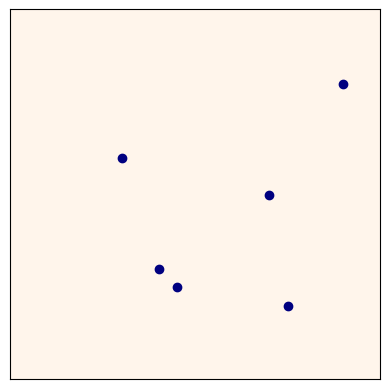

In [3]:
d = 2   # dimension of the data points
n = 6   # number of data points

y = torch.zeros((n,d), device=device)
y[0, 0] = 0.9
y[0, 1] = 0.2

y[1, 0] = 0.75
y[1, 1] = 0.8

y[2, 0] = 0.3
y[2, 1] = 0.4

y[3, 0] = 0.4
y[3, 1] = 0.7

y[4, 0] = 0.45
y[4, 1] = 0.75

y[5, 0] = 0.7
y[5, 1] = 0.5

nu = torch.ones(n, device=device)/n  # equal masses (nu is the empirical measure of the data)

# generate grid for plotting purpose
nr,nc = 256,256
extent = ((-0.5/nc, 1-0.5/nc, 1-0.5/nr, -0.5/nr))
xs = torch.linspace(0, 1, steps=nr)
ys = torch.linspace(0, 1, steps=nc)
xm, ym = torch.meshgrid(xs, ys, indexing='ij')
xm = xm.T
ym = ym.T
xgrid = torch.cat((xm.reshape(nr*nc,1),ym.reshape(nr*nc,1)),1).to(device)

# Plot data points
fig = plt.figure(dpi=100)
plt.xticks([])
plt.yticks([])
plt.imshow(np.zeros((nr,nc)),cmap = 'Oranges', extent=extent) # background
plt.scatter(y[:, 0].cpu(), y[:,1].cpu(),c='navy')
plt.show()

## Define Generator architecture

QUESTION: Examine the layers and parameters of the following generative network.

In [7]:
class Generator(torch.nn.Module): 
    
    def __init__(self, n_in, n_out, n_hid=10, nlayers=3, device=torch.device("cpu")):
        super(Generator, self).__init__()
        
        self.n_in = n_in
        self.n_out = n_out
        self.n_hid = n_hid
        self.nlayers = nlayers
        self.hidden = nn.ModuleList()
        
        for n in range(nlayers):
            n_in_t = n_in if n==0 else n_hid
            self.hidden.append(nn.Sequential(
            nn.Linear(n_in_t, n_hid),
            nn.ELU(1)
        ).to(device))
        
        self.out = nn.Sequential(
            nn.Linear(n_hid, n_out),
            nn.Sigmoid()
        ).to(device)
        
        self.apply(self._init_weights)
            

    def forward(self, x):
        for n in range(self.nlayers):
            x = self.hidden[n](x)
        x = self.out(x)
        return x


    def _init_weights(self, module):
        if isinstance(module, nn.Linear):
            torch.nn.init.xavier_uniform_(module.weight, 1.0)
            if module.bias is not None:
                module.bias.data.zero_()


QUESTION: Plot one initial configuration of the generator (draw a batch of generated points)

torch.Size([100, 2])


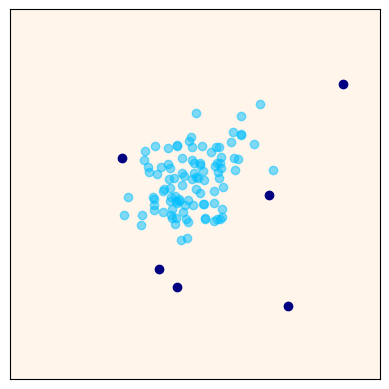

In [8]:
torch.manual_seed(0)  # initialize random seed for reproducibility

n_in = 10    # dimension of the input noise
b = 100      # batch size

# Initialize generator
G = Generator(n_in=n_in, n_out=d, n_hid=100, nlayers=3, device=device)

# Draw a batch x of generated points
#    Input noise z : standard normal with shape (b, n_in)
z = torch.randn((b, n_in), device=device)
x = G(z)

print(x.shape)

xd = x.detach()
fig = plt.figure(dpi=100)
plt.xticks([])
plt.yticks([])
plt.imshow(np.zeros((nr,nc)),cmap = 'Oranges', extent=extent) # background
plt.scatter(xd[:, 0].cpu(), xd[:,1].cpu(),c='deepskyblue',alpha=.5)
plt.scatter(y[:, 0].cpu(), y[:,1].cpu(),c='navy')
plt.show()

<br/><br/><br/><br/>

# Exercise 1: WGAN Learning

## Discriminator Architecture

QUESTION: Examine the layers and parameters of the following discriminative network.

In [9]:
# Discriminator adapted for WGAN-GP
#  Remark the absence of final sigmoid function in this case.

class DWGAN(nn.Module):
  def __init__(self, n_in, n_hid=10):
    super(DWGAN, self).__init__()

    self.n_hid = n_hid
    self.n_in = n_in

    self.fc1 = nn.Linear(n_in, n_hid)
    self.fc2 = nn.Linear(n_hid, n_hid)
    self.fc3 = nn.Linear(n_hid, 1)

  def forward(self, x):
    y = nn.LeakyReLU(negative_slope=0.2)(self.fc1(x))
    y = nn.LeakyReLU(negative_slope=0.2)(self.fc2(y))
    y = self.fc3(y)
    return y

## Weight clipping

QUESTION: For a fixed generator, train the discriminator with WGAN loss and weight clipping. 

Try changing the clip_value. What do you observe?

[0/1000], 0.001080


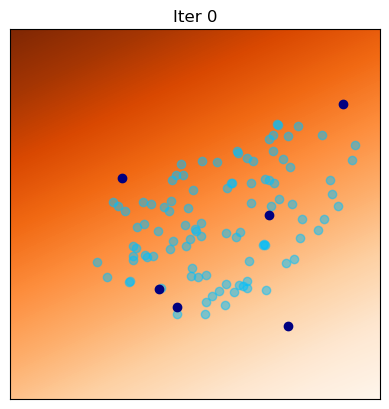

[100/1000], -0.001679


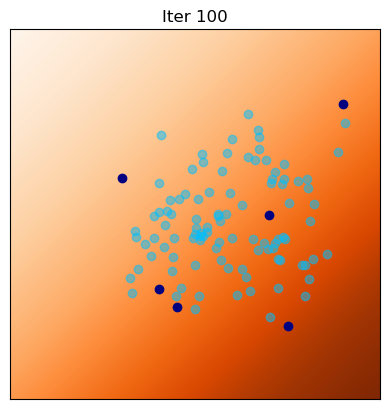

[200/1000], -0.004219


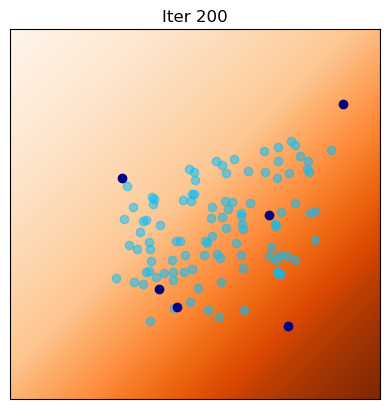

[300/1000], -0.005557


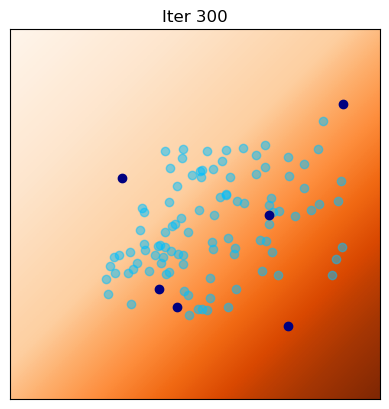

[400/1000], -0.006978


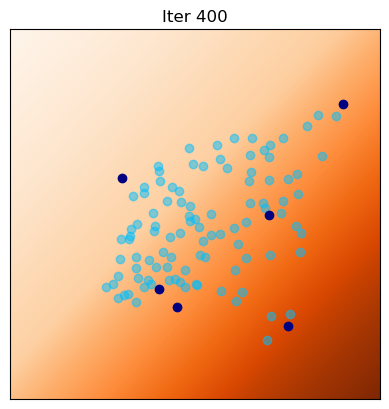

[500/1000], -0.005831


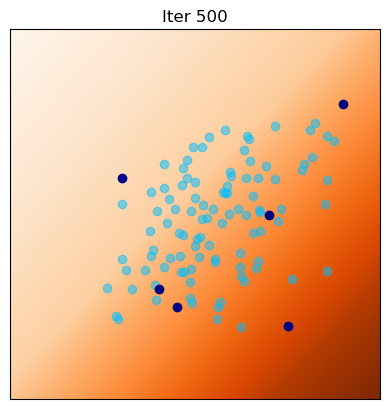

[600/1000], -0.005946


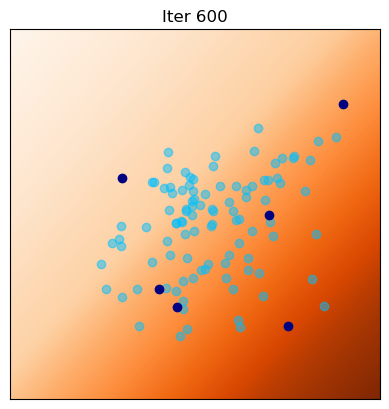

[700/1000], -0.007451


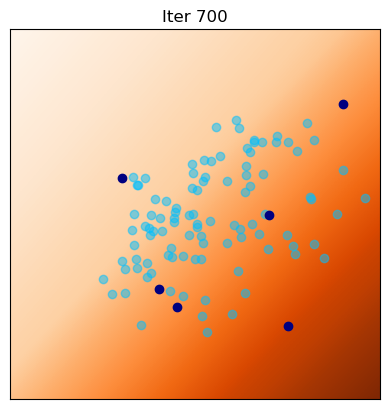

[800/1000], -0.004847


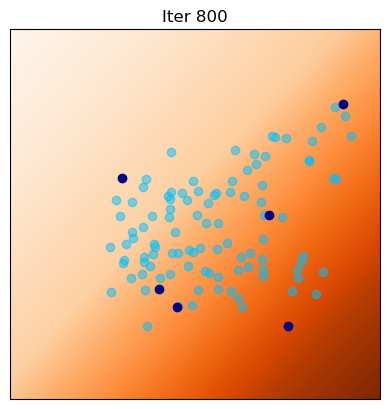

[900/1000], -0.004781


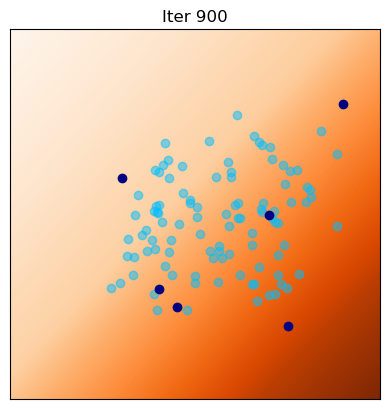

In [12]:
torch.manual_seed(1)  # initialize random seed for reproducibility

# parameters for discriminator optimization
lrdisc = 0.002
beta_1 = 0.5
beta_2 = 0.999
niterD=1000

clip_value = .1

D = DWGAN(n_in=d, n_hid=10).to(device)
optimD = optim.Adam(D.parameters(), lr=lrdisc, betas=(beta_1, beta_2))

iter_display = 100  # display current configuration each iter_display iteration

# Lists to keep track of progress
Dlosses = []
    
for iter in range(0,niterD):

    ### UPDATE OF D ###
    optimD.zero_grad()
    Dy = D(y)
    z = torch.randn(b, n_in, device=device)
    x = G(z)
    Dx = D(x.detach())
    Dloss = - torch.mean(Dy) + torch.mean(Dx)
    Dloss.backward()
    optimD.step()
    for p in D.parameters():
        p.data.clamp_(-clip_value, clip_value)

    ### SAVE LOSS ###
    Dlosst = Dloss.item()
    Dlosses.append(-Dlosst)

    if(iter%iter_display == 0):
        print('[%d/%d], %f' % (iter, niterD, Dlosst))
        Dxgrid = D(xgrid).detach().cpu().numpy().reshape(nr,nc)
        x = G(z) 
        xd = x.detach().squeeze(1)
        strtitle = 'Iter '+str(iter)
        fig = plt.figure(dpi=100)
        plt.xticks([])
        plt.yticks([])
        plt.imshow(Dxgrid,cmap = 'Oranges', extent=extent)  # discriminator
        plt.scatter(xd[:, 0].cpu(), xd[:,1].cpu(),c='deepskyblue',alpha=.5)
        plt.scatter(y[:, 0].cpu(), y[:,1].cpu(),c='navy')
        plt.title(strtitle)
        plt.show()

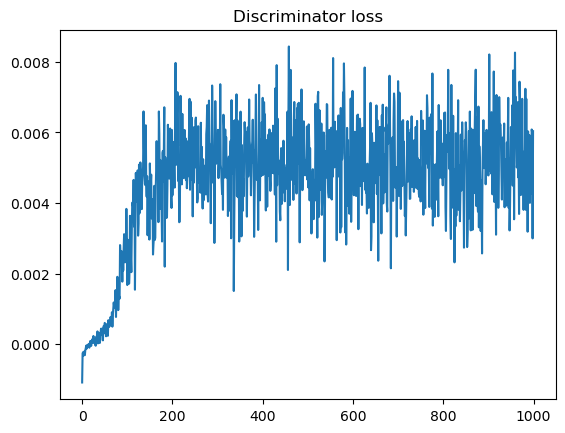

In [13]:
### Plot the evolution of the discriminator loss ###

plt.figure(dpi=100)
plt.plot(Dlosses)
plt.title('Discriminator loss')
plt.show()

## Train both the Generator and Discriminator

[1/100] 	Loss_D: -0.0053	Loss_G: 0.0916
[2/100] 	Loss_D: -0.0022	Loss_G: 0.1203
[3/100] 	Loss_D: -0.0029	Loss_G: 0.1174
[4/100] 	Loss_D: -0.0014	Loss_G: 0.1163
[5/100] 	Loss_D: -0.0036	Loss_G: 0.0439
[6/100] 	Loss_D: -0.0035	Loss_G: 0.0481
[7/100] 	Loss_D: -0.0003	Loss_G: 0.1134
[8/100] 	Loss_D: -0.0033	Loss_G: 0.1084
[9/100] 	Loss_D: -0.0034	Loss_G: 0.0676
[10/100] 	Loss_D: -0.0046	Loss_G: 0.0600


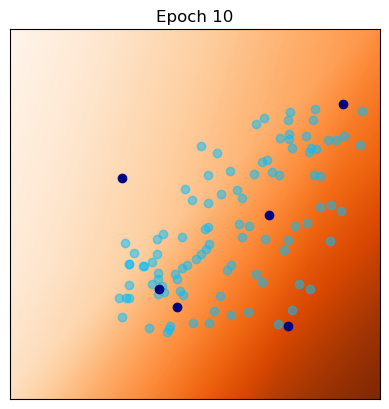

[11/100] 	Loss_D: -0.0004	Loss_G: 0.0602
[12/100] 	Loss_D: -0.0061	Loss_G: 0.0960
[13/100] 	Loss_D: -0.0050	Loss_G: 0.0913
[14/100] 	Loss_D: 0.0004	Loss_G: 0.0569
[15/100] 	Loss_D: -0.0059	Loss_G: 0.0381
[16/100] 	Loss_D: -0.0085	Loss_G: 0.1011
[17/100] 	Loss_D: -0.0097	Loss_G: 0.0924
[18/100] 	Loss_D: -0.0101	Loss_G: 0.0896
[19/100] 	Loss_D: -0.0054	Loss_G: 0.0800
[20/100] 	Loss_D: -0.0027	Loss_G: 0.0282


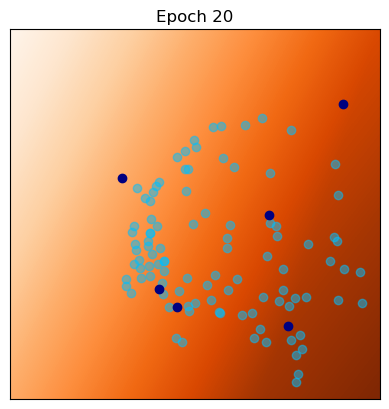

[21/100] 	Loss_D: -0.0007	Loss_G: 0.0612
[22/100] 	Loss_D: -0.0025	Loss_G: 0.0394
[23/100] 	Loss_D: -0.0028	Loss_G: 0.0397
[24/100] 	Loss_D: -0.0063	Loss_G: 0.0049
[25/100] 	Loss_D: -0.0050	Loss_G: -0.0063
[26/100] 	Loss_D: -0.0027	Loss_G: -0.0041
[27/100] 	Loss_D: -0.0047	Loss_G: 0.0241
[28/100] 	Loss_D: -0.0000	Loss_G: 0.0348
[29/100] 	Loss_D: -0.0041	Loss_G: 0.0434
[30/100] 	Loss_D: -0.0024	Loss_G: 0.0240


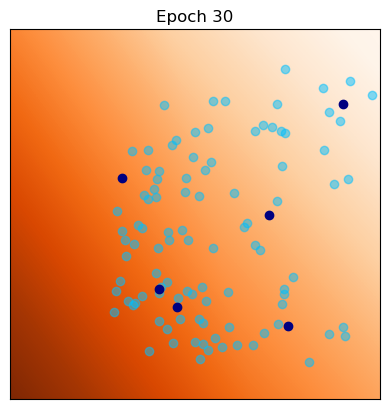

[31/100] 	Loss_D: -0.0023	Loss_G: 0.0173
[32/100] 	Loss_D: 0.0019	Loss_G: 0.0394
[33/100] 	Loss_D: 0.0002	Loss_G: 0.0293
[34/100] 	Loss_D: -0.0013	Loss_G: 0.0638
[35/100] 	Loss_D: -0.0013	Loss_G: 0.0643
[36/100] 	Loss_D: -0.0004	Loss_G: 0.0359
[37/100] 	Loss_D: -0.0025	Loss_G: 0.0344
[38/100] 	Loss_D: -0.0009	Loss_G: 0.0615
[39/100] 	Loss_D: -0.0005	Loss_G: 0.0437
[40/100] 	Loss_D: -0.0022	Loss_G: 0.0399


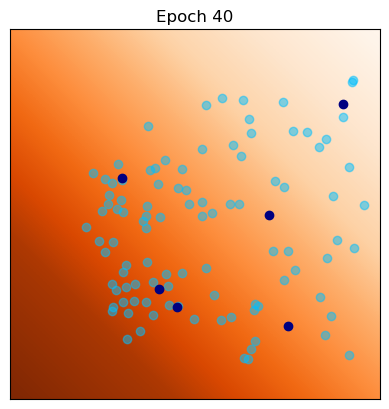

[41/100] 	Loss_D: -0.0032	Loss_G: -0.0054
[42/100] 	Loss_D: -0.0026	Loss_G: 0.0290
[43/100] 	Loss_D: -0.0029	Loss_G: 0.0523
[44/100] 	Loss_D: -0.0024	Loss_G: 0.0617
[45/100] 	Loss_D: -0.0023	Loss_G: 0.0639
[46/100] 	Loss_D: -0.0006	Loss_G: 0.0474
[47/100] 	Loss_D: -0.0010	Loss_G: 0.0602
[48/100] 	Loss_D: -0.0024	Loss_G: 0.0567
[49/100] 	Loss_D: -0.0007	Loss_G: 0.0573
[50/100] 	Loss_D: -0.0006	Loss_G: 0.0805


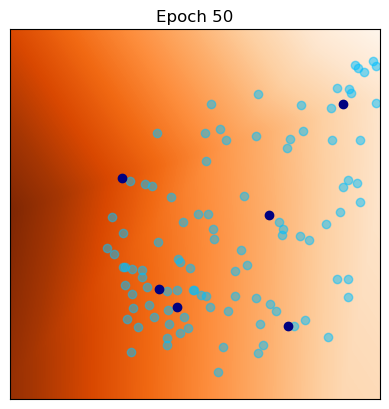

[51/100] 	Loss_D: -0.0032	Loss_G: 0.0811
[52/100] 	Loss_D: -0.0012	Loss_G: 0.0845
[53/100] 	Loss_D: -0.0008	Loss_G: 0.0423
[54/100] 	Loss_D: -0.0015	Loss_G: 0.0584
[55/100] 	Loss_D: -0.0013	Loss_G: 0.0592
[56/100] 	Loss_D: -0.0012	Loss_G: 0.0784
[57/100] 	Loss_D: -0.0002	Loss_G: 0.0651
[58/100] 	Loss_D: 0.0000	Loss_G: 0.0962
[59/100] 	Loss_D: -0.0021	Loss_G: 0.0772
[60/100] 	Loss_D: -0.0025	Loss_G: 0.1048


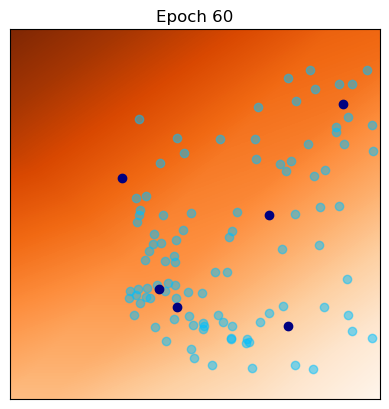

[61/100] 	Loss_D: -0.0008	Loss_G: 0.0896
[62/100] 	Loss_D: -0.0007	Loss_G: 0.0258
[63/100] 	Loss_D: -0.0014	Loss_G: 0.0253
[64/100] 	Loss_D: -0.0023	Loss_G: 0.0795
[65/100] 	Loss_D: -0.0022	Loss_G: 0.0860
[66/100] 	Loss_D: -0.0009	Loss_G: 0.0469
[67/100] 	Loss_D: -0.0014	Loss_G: 0.0658
[68/100] 	Loss_D: -0.0015	Loss_G: 0.0657
[69/100] 	Loss_D: -0.0015	Loss_G: 0.0948
[70/100] 	Loss_D: -0.0002	Loss_G: 0.0923


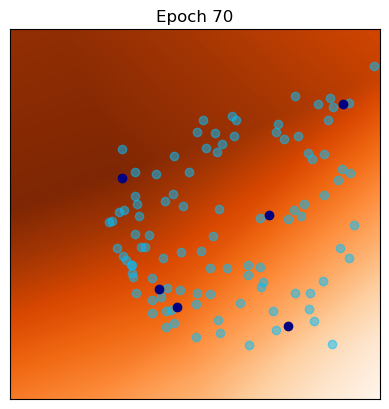

[71/100] 	Loss_D: 0.0002	Loss_G: -0.0123
[72/100] 	Loss_D: 0.0008	Loss_G: 0.0080
[73/100] 	Loss_D: -0.0024	Loss_G: 0.0456
[74/100] 	Loss_D: -0.0026	Loss_G: 0.0435
[75/100] 	Loss_D: -0.0053	Loss_G: 0.0498
[76/100] 	Loss_D: 0.0003	Loss_G: 0.0665
[77/100] 	Loss_D: -0.0063	Loss_G: 0.0410
[78/100] 	Loss_D: -0.0074	Loss_G: 0.0423
[79/100] 	Loss_D: -0.0072	Loss_G: -0.0070
[80/100] 	Loss_D: -0.0090	Loss_G: 0.0522


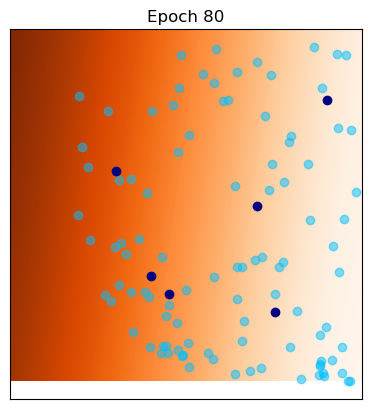

[81/100] 	Loss_D: -0.0110	Loss_G: 0.0273
[82/100] 	Loss_D: -0.0024	Loss_G: 0.0145
[83/100] 	Loss_D: -0.0028	Loss_G: -0.0079
[84/100] 	Loss_D: 0.0015	Loss_G: -0.0084
[85/100] 	Loss_D: -0.0076	Loss_G: 0.0109
[86/100] 	Loss_D: -0.0054	Loss_G: 0.0042
[87/100] 	Loss_D: 0.0010	Loss_G: 0.0356
[88/100] 	Loss_D: 0.0019	Loss_G: 0.0394
[89/100] 	Loss_D: -0.0033	Loss_G: 0.0163
[90/100] 	Loss_D: -0.0054	Loss_G: -0.0463


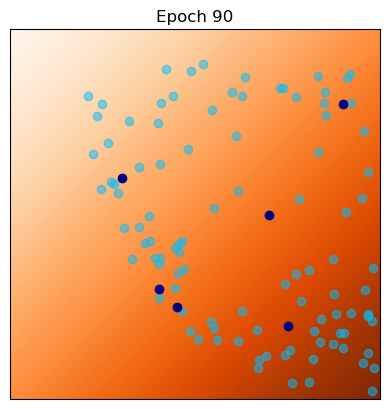

[91/100] 	Loss_D: -0.0015	Loss_G: 0.0073
[92/100] 	Loss_D: -0.0011	Loss_G: 0.0524
[93/100] 	Loss_D: -0.0036	Loss_G: 0.0508
[94/100] 	Loss_D: -0.0097	Loss_G: 0.0322
[95/100] 	Loss_D: -0.0039	Loss_G: 0.0302
[96/100] 	Loss_D: -0.0028	Loss_G: 0.0282
[97/100] 	Loss_D: -0.0002	Loss_G: 0.1157
[98/100] 	Loss_D: -0.0038	Loss_G: 0.1721
[99/100] 	Loss_D: -0.0024	Loss_G: 0.1802


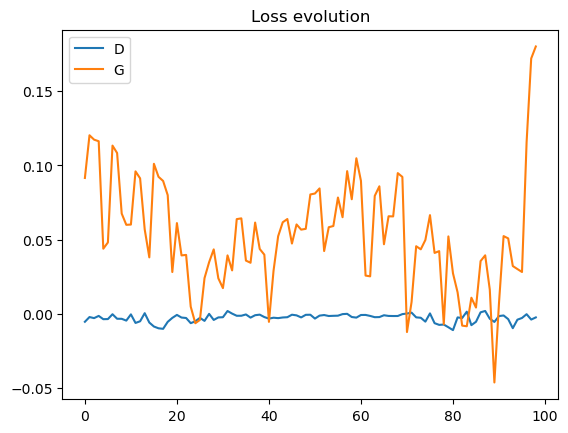

<All keys matched successfully>

In [14]:
lr = 0.002   # learning rate for generator

## parameters for training
n_epochs = 100
niterD=1000
niterG=10

torch.manual_seed(1)  # initialize random seed for reproducibility

# Initialize generators and discriminators
G = Generator(n_in=n_in, n_out=d, n_hid=10, nlayers=3, device=device)
optimG = optim.Adam(G.parameters(), lr=lr)

D = DWGAN(n_in=d, n_hid=10).to(device)
optimD = optim.Adam(D.parameters(), lr=lrdisc, betas=(beta_1, beta_2))


Glosses = []
Dlosses = []

clip_value = .1
iter_display = 10

# Main loop
for epoch in range(1,n_epochs):
    
    ############################
    ### Train discriminator (niterD iterations)
    ############################
       
    for iter in range(0,niterD):
        optimD.zero_grad()
        Dy = D(y)
        z = torch.randn(b, n_in, device=device)
        x = G(z)
        Dx = D(x.detach())
        Dloss = - torch.mean(Dy) + torch.mean(Dx)
        Dloss.backward()
        optimD.step()
        for p in D.parameters():
            p.data.clamp_(-clip_value, clip_value)
      
    ############################
    ### Train generator (niterG iterations)
    ############################
    for iter in range(0,niterG):
        optimG.zero_grad()
        z = torch.randn(b, n_in, device=device)
        x = G(z)
        Gloss = -torch.mean(D(x))
        Gloss.backward()
        optimG.step()

    # Output training stats
    print('[%d/%d] \tLoss_D: %.4f\tLoss_G: %.4f'
      % (epoch, n_epochs, Dloss.item(), Gloss.item()))
    Glosses.append(Gloss.item())
    Dlosses.append(Dloss.item())

    if(epoch % iter_display == 0):
        Dxgrid = D(xgrid).detach().cpu().numpy().reshape(nr,nc)
        z = torch.randn(b, n_in, device=device)
        x = G(z) 
        xd = x.detach().squeeze(1)
        strtitle = 'Epoch '+str(epoch)
        fig = plt.figure(dpi=100)
        plt.xticks([])
        plt.yticks([])
        plt.imshow(Dxgrid,cmap = 'Oranges', extent=extent)
        plt.scatter(xd[:, 0].cpu(), xd[:,1].cpu(),c='deepskyblue',alpha=.5)
        plt.scatter(y[:, 0].cpu(), y[:,1].cpu(),c='navy')
        plt.title(strtitle)
        plt.show()
       
    
### Plot the evolution of the discriminator and generator losses ###

plt.figure(dpi=100)
plt.plot(Dlosses,label='D')
plt.plot(Glosses,label='G')
plt.title('Loss evolution')
plt.legend()
plt.show()

# Save final generator for later use
wganwc = Generator(n_in=n_in, n_out=d, n_hid=10, nlayers=3, device=device)
wganwc.load_state_dict(G.state_dict())

## Estimate the Lipschitz constant of the discriminator

QUESTION: Implement a function computing an estimation of the Lipschitz constant of $D$ on points that are interpolated between $x$ and $y$.

Use this function to examine the Lipschitz constant of the final discriminator obtained with WGAN-WC.

In [15]:
def lipconstant(D,x,y):
    # Calculate interpolation
    b = x.shape[0]
    n = y.shape[0]
    alpha = torch.rand((b,n,1),device=device)
    interp = (alpha * y[None,:,:] + (1 - alpha) * x[:,None,:]).flatten(end_dim=1)
    interp.requires_grad_()

    # Calculate probability of interpolated examples
    Di = D(interp).view(-1)

    # Calculate gradients of probabilities with respect to examples
    gradout = torch.ones(Di.size()).to(device)
    gradients = torch.autograd.grad(outputs=Di, inputs=interp, grad_outputs=gradout,
       create_graph=True, retain_graph=True)[0]

    # Derivatives of the gradient close to 0 can cause problems because of
    # the square root, so manually calculate norm and add epsilon
    gradients_norm = torch.sqrt(torch.sum(gradients ** 2, dim=1))

    # Return gradient penalty
    return torch.mean(gradients_norm)

lipconstant(D,x,y)

# # simpler version without interpolation:
# def lipconstant(D,x,y):
#     # Calculate interpolation
#     b = min(x.shape[0],y.shape[0])
#     alpha = torch.rand((b,1),device=device)
#     interp = alpha * y[0:b,:] + (1 - alpha) * x[0:b,:]
#     interp.requires_grad_()

#     # Calculate probability of interpolated examples
#     Di = D(interp).view(-1)

#     # Calculate gradients of probabilities with respect to examples
#     gradout = torch.ones(Di.size()).to(device)
#     gradients = torch.autograd.grad(outputs=Di, inputs=interp, grad_outputs=gradout,
#        create_graph=True, retain_graph=True)[0]

#     # Derivatives of the gradient close to 0 can cause problems because of
#     # the square root, so manually calculate norm and add epsilon
#     gradients_norm = torch.sqrt(torch.sum(gradients ** 2, dim=1))

#     # Return gradient penalty
#     return torch.mean(gradients_norm)

# lipconstant(D,x,y)

tensor(0.0406, device='cuda:0', grad_fn=<MeanBackward0>)

## Gradient Penalty

QUESTION: Implement a function computing the gradient penalty of $D$ on points that are interpolated between $x$ and $y$.

In [25]:
def gradient_penalty(D,x,y):
    # Calculate interpolation
    b = x.shape[0]
    n = y.shape[0]
    alpha = torch.rand((b,n,1),device=device)
    interp = (alpha * y[None,:,:] + (1 - alpha) * x[:,None,:]).flatten(end_dim=1)
    interp.requires_grad_()

    # Calculate probability of interpolated examples
    Di = D(interp).view(-1)

    # Calculate gradients of probabilities with respect to examples
    gradout = torch.ones(Di.size()).to(device)
    gradients = torch.autograd.grad(outputs=Di, inputs=interp, grad_outputs=gradout,
       create_graph=True, retain_graph=True)[0]

    # Derivatives of the gradient close to 0 can cause problems because of
    # the square root, so manually calculate norm and add epsilon
    gradients_norm = torch.sqrt(torch.sum(gradients ** 2, dim=1) + 1e-12)

    # Return gradient penalty
    return ((gradients_norm - 1) ** 2).mean()
#     return ((gradients_norm - 1) ** 2*(gradients_norm>1)).mean()

print(gradient_penalty(D,x,y))

# # simpler version without interpolation:
# def gradient_penalty(D,x,y):
#     # Calculate interpolation
#     b = min(x.shape[0],y.shape[0])
#     alpha = torch.rand((b,1),device=device)
#     interp = alpha * y[0:b,:] + (1 - alpha) * x[0:b,:]
#     interp.requires_grad_()

#     # Calculate probability of interpolated examples
#     Di = D(interp).view(-1)

#     # Calculate gradients of probabilities with respect to examples
#     gradout = torch.ones(Di.size()).to(device)
#     gradients = torch.autograd.grad(outputs=Di, inputs=interp, grad_outputs=gradout,
#        create_graph=True, retain_graph=True)[0]

#     # Derivatives of the gradient close to 0 can cause problems because of
#     # the square root, so manually calculate norm and add epsilon
#     gradients_norm = torch.sqrt(torch.sum(gradients ** 2, dim=1) + 1e-12)

#     # Return gradient penalty
#     return ((gradients_norm - 1) ** 2).mean()
# #     return ((gradients_norm - 1) ** 2*(gradients_norm>1)).mean()

# print(gradient_penalty(D,x,y))

tensor(0.5885, device='cuda:0', grad_fn=<MeanBackward0>)


## Train the WGAN-GP discriminator for a fixed generator

QUESTION: Complete the following code at the blocks ###...###. 

Adjust the weight of the gradient penalty (parameter `gpw`) to get a Lipschitz constant $\leq 1$.

How would you judge the resulting discriminator?

[0/1000], Dloss=9.2449, Lip(D)=0.0422


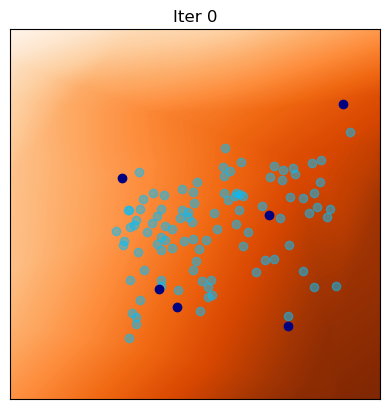

[100/1000], Dloss=0.3013, Lip(D)=0.9866


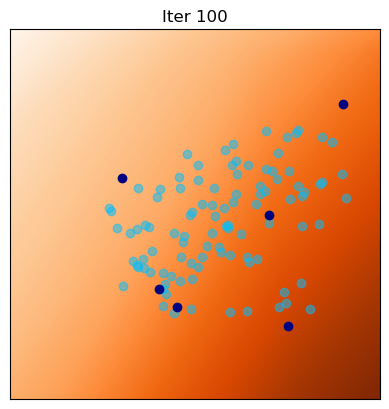

[200/1000], Dloss=0.2355, Lip(D)=1.0203


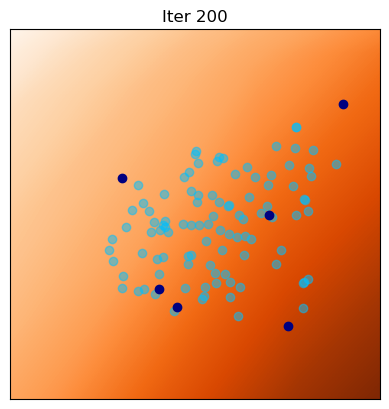

[300/1000], Dloss=0.2001, Lip(D)=0.9190


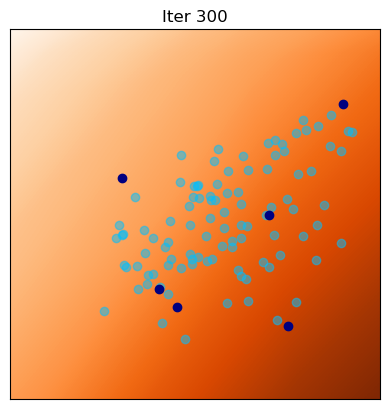

[400/1000], Dloss=0.1656, Lip(D)=0.8885


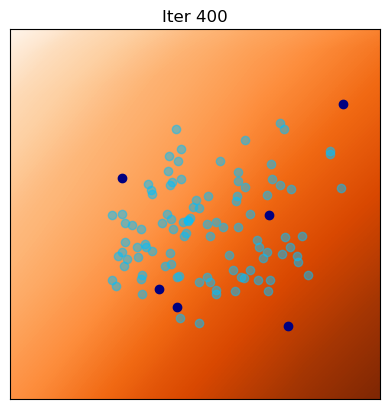

[500/1000], Dloss=0.1082, Lip(D)=0.9183


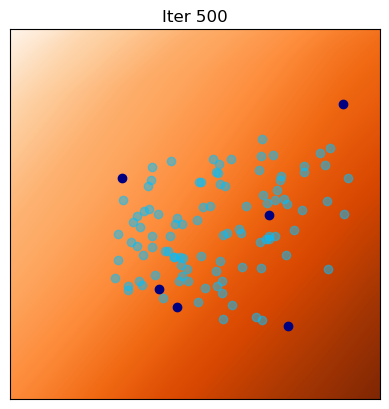

[600/1000], Dloss=0.0620, Lip(D)=1.0003


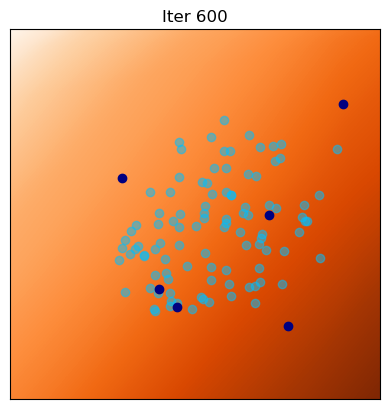

[700/1000], Dloss=-0.0118, Lip(D)=1.0128


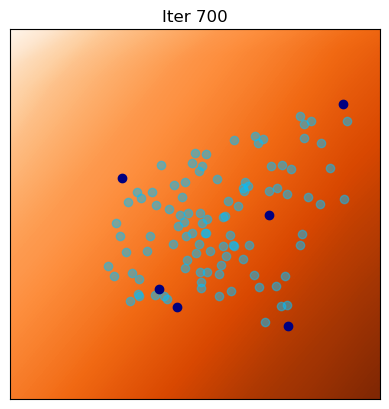

[800/1000], Dloss=-0.0377, Lip(D)=1.0139


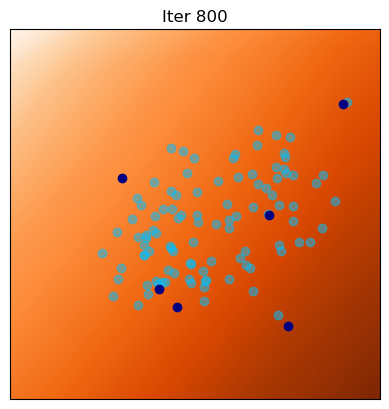

[900/1000], Dloss=-0.0520, Lip(D)=0.9584


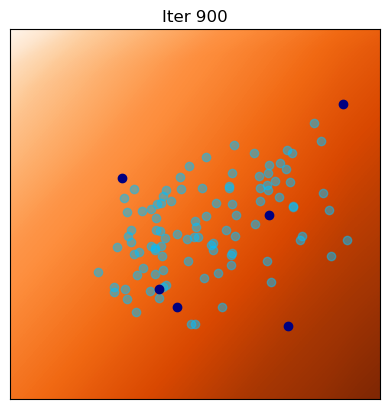

In [26]:
torch.manual_seed(1)  # initialize random seed for reproducibility

# Reinitialize generators and discriminators
G = Generator(n_in=n_in, n_out=d, n_hid=10, nlayers=3, device=device)
optimG = optim.Adam(G.parameters(), lr=lr)

D = DWGAN(n_in=d, n_hid=10).to(device)
optimD = optim.Adam(D.parameters(), lr=lrdisc, betas=(beta_1, beta_2))

# parameters for discriminator optimization
lrdisc = 0.002
beta_1 = 0.5
beta_2 = 0.999
gpw = 10
niterD=1000

D = DWGAN(n_in=d, n_hid=10).to(device)
optimD = optim.Adam(D.parameters(), lr=lrdisc, betas=(beta_1, beta_2))

iter_display = 100  # display current configuration each iter_display iteration

# Lists to keep track of progress
Dlosses = []
    
for iter in range(0,niterD):

    ### UPDATE OF D ###
    optimD.zero_grad()
    Dy = D(y)
    z = torch.randn(b, n_in, device=device)
    x = G(z)
    Dx = D(x.detach())
    Dloss = - torch.mean(Dy) + torch.mean(Dx) + gpw *gradient_penalty(D,x,y)
    Dloss.backward()
    optimD.step()

    ### SAVE LOSS ###
    Dlosst = Dloss.item()
    Dlosses.append(-Dlosst)

    if(iter%iter_display == 0):
        print('[%d/%d], Dloss=%.4f, Lip(D)=%.4f' % (iter, niterD, Dlosst,lipconstant(D,x,y).item()))
        Dxgrid = D(xgrid).detach().cpu().numpy().reshape(nr,nc)
        x = G(z) 
        xd = x.detach().squeeze(1)
        strtitle = 'Iter '+str(iter)
        fig = plt.figure(dpi=100)
        plt.xticks([])
        plt.yticks([])
        plt.imshow(Dxgrid,cmap = 'Oranges', extent=extent)  # discriminator
        plt.scatter(xd[:, 0].cpu(), xd[:,1].cpu(),c='deepskyblue',alpha=.5)
        plt.scatter(y[:, 0].cpu(), y[:,1].cpu(),c='navy')
        plt.title(strtitle)
        plt.show()


Final estimated Lipschitz constant =  1.0104169845581055


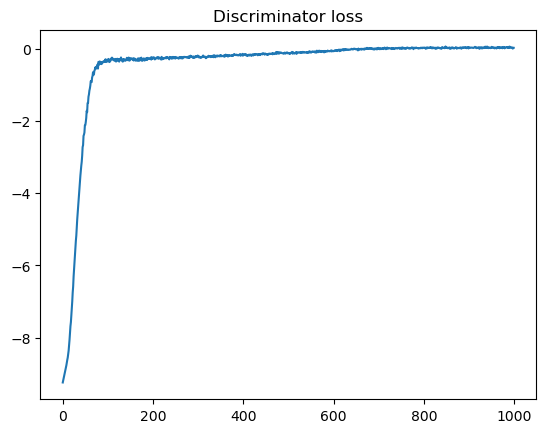

In [27]:
print('Final estimated Lipschitz constant = ',lipconstant(D,x,y).item())

plt.figure(dpi=100)
plt.plot(Dlosses)
plt.title('Discriminator loss')
plt.show()

QUESTION: Learn both generator and discriminator with the gradient penalty term

[1/100] 	Loss_D: 0.0417	Loss_G: 1.2113	Lip(D)=0.7795
[2/100] 	Loss_D: -0.2090	Loss_G: 0.0729	Lip(D)=1.8056
[3/100] 	Loss_D: -0.1647	Loss_G: -0.1830	Lip(D)=1.5510
[4/100] 	Loss_D: -0.0590	Loss_G: -0.2926	Lip(D)=1.1163
[5/100] 	Loss_D: -0.0214	Loss_G: -0.2628	Lip(D)=0.9855


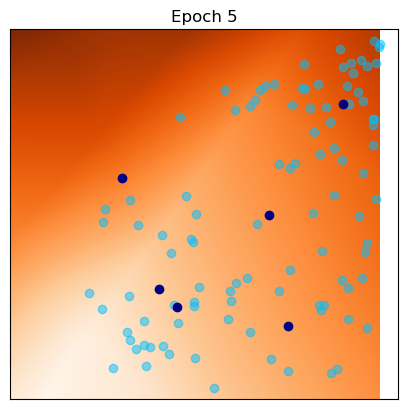

[6/100] 	Loss_D: -0.1302	Loss_G: 0.5875	Lip(D)=1.7075
[7/100] 	Loss_D: -0.1149	Loss_G: 0.4870	Lip(D)=1.5528
[8/100] 	Loss_D: -0.1597	Loss_G: 0.3852	Lip(D)=1.6879
[9/100] 	Loss_D: -0.2291	Loss_G: 0.2515	Lip(D)=1.1087
[10/100] 	Loss_D: -0.2295	Loss_G: -0.0651	Lip(D)=1.6616


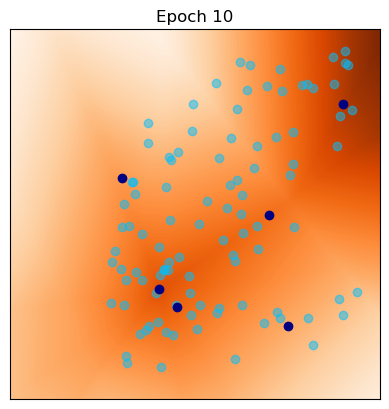

[11/100] 	Loss_D: -0.1447	Loss_G: -0.1134	Lip(D)=1.4195
[12/100] 	Loss_D: -0.1234	Loss_G: -0.0711	Lip(D)=1.1402
[13/100] 	Loss_D: -0.1105	Loss_G: -0.0589	Lip(D)=1.3412
[14/100] 	Loss_D: -0.0886	Loss_G: 0.2115	Lip(D)=1.4706
[15/100] 	Loss_D: -0.1395	Loss_G: 0.2816	Lip(D)=1.5399


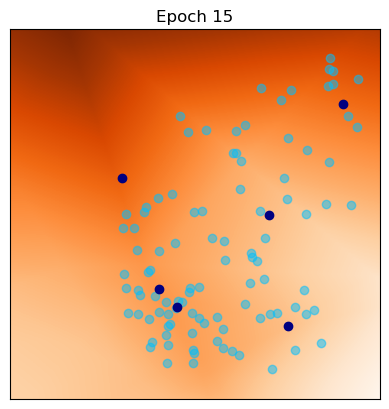

[16/100] 	Loss_D: -0.0605	Loss_G: 0.1729	Lip(D)=1.3130
[17/100] 	Loss_D: -0.0949	Loss_G: -0.1001	Lip(D)=1.4479
[18/100] 	Loss_D: -0.0854	Loss_G: -0.3478	Lip(D)=1.4588
[19/100] 	Loss_D: -0.0727	Loss_G: -0.4965	Lip(D)=0.9258
[20/100] 	Loss_D: -0.0536	Loss_G: -0.0631	Lip(D)=0.9603


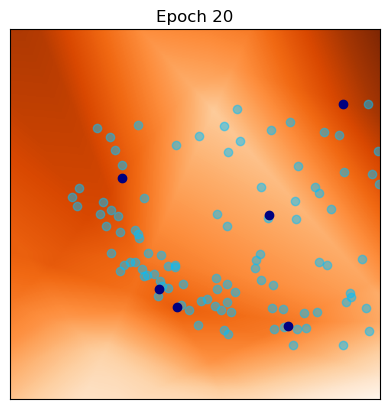

[21/100] 	Loss_D: -0.0876	Loss_G: 0.2126	Lip(D)=1.2340
[22/100] 	Loss_D: -0.0775	Loss_G: 0.1109	Lip(D)=1.2317
[23/100] 	Loss_D: -0.0845	Loss_G: -0.0639	Lip(D)=1.0935
[24/100] 	Loss_D: -0.0769	Loss_G: -0.2218	Lip(D)=1.2716
[25/100] 	Loss_D: -0.0456	Loss_G: -0.5308	Lip(D)=1.1682


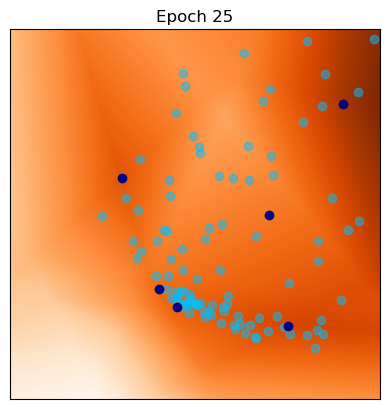

[26/100] 	Loss_D: -0.0000	Loss_G: -0.7200	Lip(D)=1.0172
[27/100] 	Loss_D: -0.0407	Loss_G: -0.0948	Lip(D)=1.1132
[28/100] 	Loss_D: -0.0845	Loss_G: 0.2342	Lip(D)=1.4015
[29/100] 	Loss_D: -0.1224	Loss_G: 0.3447	Lip(D)=1.3957
[30/100] 	Loss_D: -0.0832	Loss_G: 0.2017	Lip(D)=1.2025


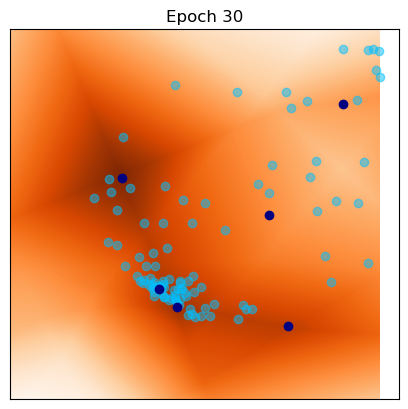

[31/100] 	Loss_D: -0.1045	Loss_G: -0.3728	Lip(D)=1.7462
[32/100] 	Loss_D: -0.1208	Loss_G: -0.4899	Lip(D)=1.3699
[33/100] 	Loss_D: -0.0560	Loss_G: 0.1225	Lip(D)=0.9500
[34/100] 	Loss_D: -0.0824	Loss_G: 0.3974	Lip(D)=1.2809
[35/100] 	Loss_D: -0.0688	Loss_G: 0.3286	Lip(D)=1.1789


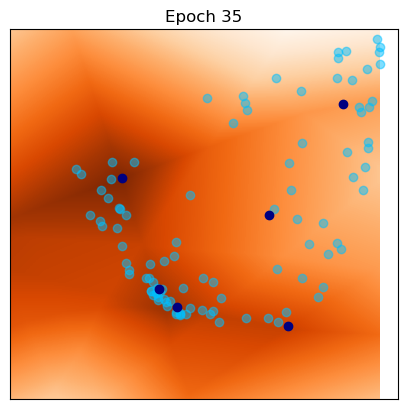

[36/100] 	Loss_D: -0.0739	Loss_G: -0.1030	Lip(D)=0.9861
[37/100] 	Loss_D: -0.0512	Loss_G: -0.4746	Lip(D)=0.9968
[38/100] 	Loss_D: -0.0714	Loss_G: -0.6399	Lip(D)=1.1953
[39/100] 	Loss_D: -0.0830	Loss_G: -0.2668	Lip(D)=1.1108
[40/100] 	Loss_D: -0.0829	Loss_G: -0.1036	Lip(D)=1.0871


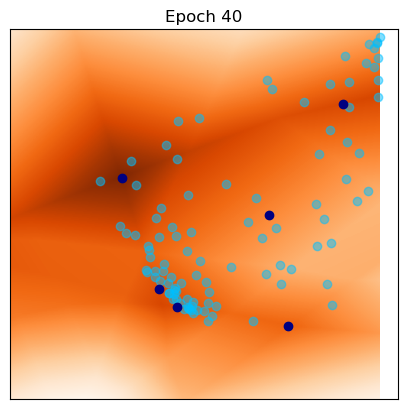

[41/100] 	Loss_D: -0.0792	Loss_G: -0.2110	Lip(D)=1.1681
[42/100] 	Loss_D: -0.0412	Loss_G: -0.3934	Lip(D)=1.5227
[43/100] 	Loss_D: -0.0645	Loss_G: -0.8927	Lip(D)=1.1403
[44/100] 	Loss_D: -0.0394	Loss_G: -0.9492	Lip(D)=1.2579
[45/100] 	Loss_D: -0.0423	Loss_G: -0.5296	Lip(D)=1.4217


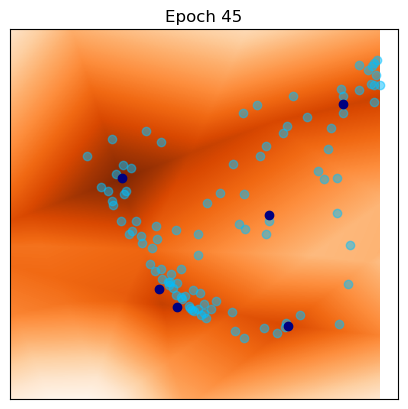

[46/100] 	Loss_D: -0.0397	Loss_G: -0.4197	Lip(D)=0.9998
[47/100] 	Loss_D: -0.0499	Loss_G: -0.8132	Lip(D)=1.0719
[48/100] 	Loss_D: -0.0208	Loss_G: -1.0647	Lip(D)=1.1383
[49/100] 	Loss_D: -0.0400	Loss_G: -1.0485	Lip(D)=0.8496
[50/100] 	Loss_D: -0.0343	Loss_G: -0.8475	Lip(D)=1.3027


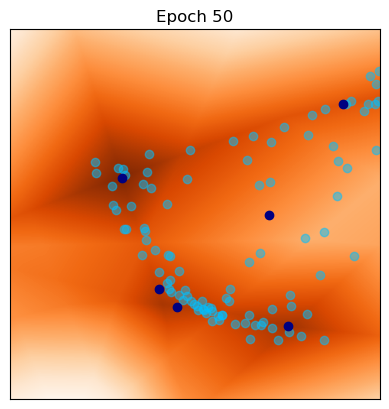

[51/100] 	Loss_D: -0.0224	Loss_G: -0.9166	Lip(D)=1.0016
[52/100] 	Loss_D: -0.0352	Loss_G: -0.9360	Lip(D)=1.1073
[53/100] 	Loss_D: -0.0272	Loss_G: -1.3522	Lip(D)=0.9365
[54/100] 	Loss_D: -0.0148	Loss_G: -1.6063	Lip(D)=1.3881
[55/100] 	Loss_D: -0.0301	Loss_G: -1.2729	Lip(D)=1.1135


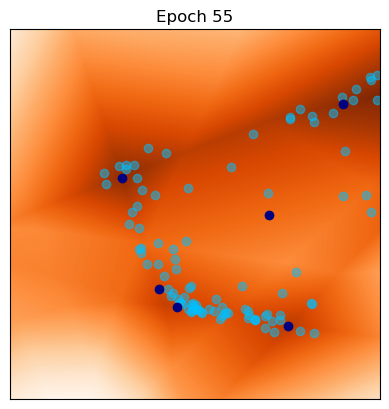

[56/100] 	Loss_D: -0.0355	Loss_G: -1.0813	Lip(D)=1.0362
[57/100] 	Loss_D: -0.0242	Loss_G: -1.3076	Lip(D)=1.0328
[58/100] 	Loss_D: -0.0026	Loss_G: -2.1500	Lip(D)=1.2670
[59/100] 	Loss_D: -0.0006	Loss_G: -2.0023	Lip(D)=1.1306
[60/100] 	Loss_D: -0.0545	Loss_G: -1.0564	Lip(D)=1.3194


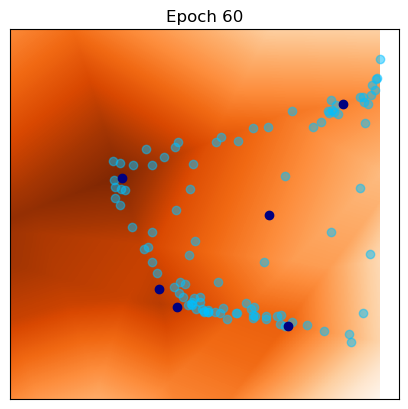

[61/100] 	Loss_D: -0.0645	Loss_G: -1.1108	Lip(D)=1.2414
[62/100] 	Loss_D: -0.0346	Loss_G: -1.7037	Lip(D)=1.1031
[63/100] 	Loss_D: -0.0664	Loss_G: -2.5301	Lip(D)=1.2122
[64/100] 	Loss_D: -0.0479	Loss_G: -2.5165	Lip(D)=1.0941
[65/100] 	Loss_D: -0.0390	Loss_G: -2.2027	Lip(D)=0.9493


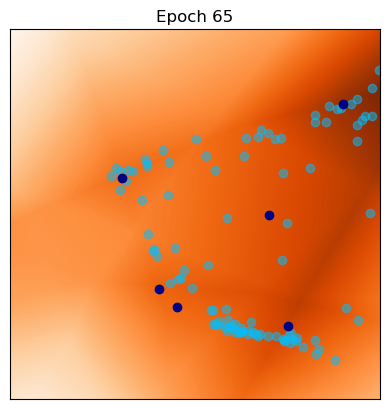

[66/100] 	Loss_D: -0.0937	Loss_G: -0.9785	Lip(D)=1.6228
[67/100] 	Loss_D: -0.0425	Loss_G: -1.2953	Lip(D)=1.0812
[68/100] 	Loss_D: -0.0545	Loss_G: -1.8663	Lip(D)=1.0507
[69/100] 	Loss_D: -0.0723	Loss_G: -2.1801	Lip(D)=1.1477
[70/100] 	Loss_D: -0.0822	Loss_G: -2.2150	Lip(D)=1.0892


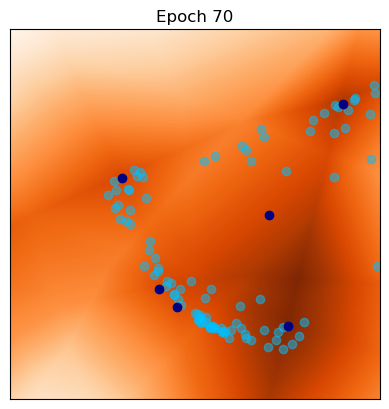

[71/100] 	Loss_D: -0.1042	Loss_G: -2.1718	Lip(D)=1.4697
[72/100] 	Loss_D: -0.1168	Loss_G: -2.3866	Lip(D)=1.0957
[73/100] 	Loss_D: -0.0950	Loss_G: -2.7503	Lip(D)=1.1921
[74/100] 	Loss_D: -0.1321	Loss_G: -3.1926	Lip(D)=1.3747
[75/100] 	Loss_D: -0.1230	Loss_G: -3.1135	Lip(D)=1.0429


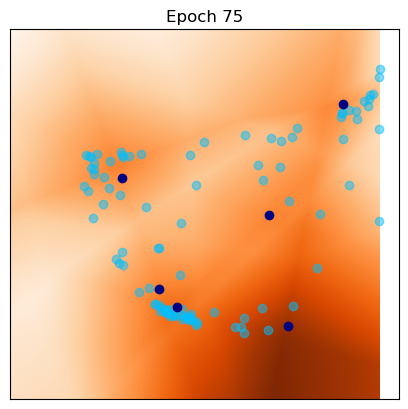

[76/100] 	Loss_D: -0.0988	Loss_G: -3.3834	Lip(D)=2.1144
[77/100] 	Loss_D: -0.1036	Loss_G: -3.3531	Lip(D)=1.1609
[78/100] 	Loss_D: -0.1237	Loss_G: -2.7073	Lip(D)=1.1662
[79/100] 	Loss_D: -0.1109	Loss_G: -2.8104	Lip(D)=1.4017
[80/100] 	Loss_D: -0.0853	Loss_G: -3.0248	Lip(D)=1.0433


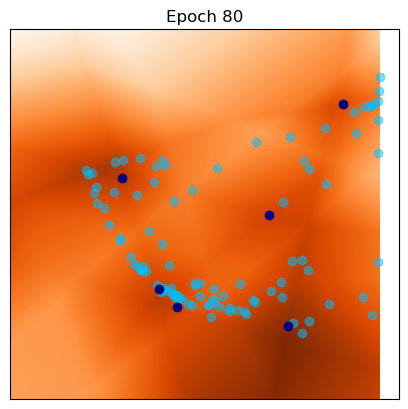

[81/100] 	Loss_D: -0.0804	Loss_G: -3.2667	Lip(D)=1.3610
[82/100] 	Loss_D: -0.0690	Loss_G: -3.3135	Lip(D)=1.3492
[83/100] 	Loss_D: -0.0857	Loss_G: -3.2208	Lip(D)=1.3336
[84/100] 	Loss_D: -0.1032	Loss_G: -3.0692	Lip(D)=1.1303
[85/100] 	Loss_D: -0.0983	Loss_G: -3.3121	Lip(D)=1.4141


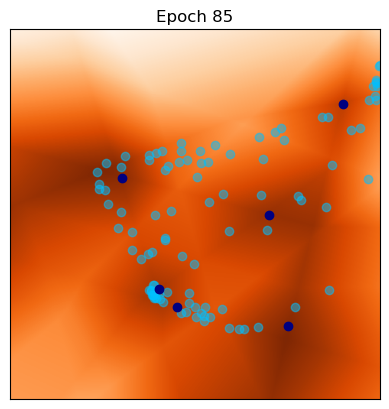

[86/100] 	Loss_D: -0.1009	Loss_G: -3.4231	Lip(D)=1.4250
[87/100] 	Loss_D: -0.0915	Loss_G: -3.5561	Lip(D)=1.1715
[88/100] 	Loss_D: -0.0998	Loss_G: -3.5667	Lip(D)=1.1923
[89/100] 	Loss_D: -0.1056	Loss_G: -3.6192	Lip(D)=1.4169
[90/100] 	Loss_D: -0.1004	Loss_G: -3.5871	Lip(D)=1.2616


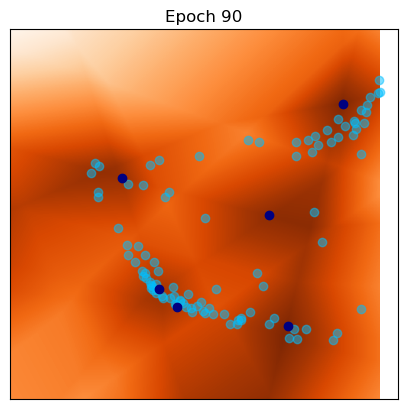

[91/100] 	Loss_D: -0.0930	Loss_G: -3.7373	Lip(D)=1.1427
[92/100] 	Loss_D: -0.0933	Loss_G: -3.8568	Lip(D)=1.2390
[93/100] 	Loss_D: -0.0799	Loss_G: -3.7999	Lip(D)=1.1972
[94/100] 	Loss_D: -0.1022	Loss_G: -3.9178	Lip(D)=1.0934
[95/100] 	Loss_D: -0.0875	Loss_G: -3.9296	Lip(D)=1.1951


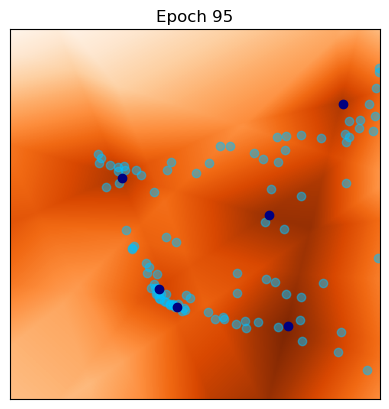

[96/100] 	Loss_D: -0.0834	Loss_G: -4.1110	Lip(D)=1.4261
[97/100] 	Loss_D: -0.0837	Loss_G: -3.9714	Lip(D)=1.5810
[98/100] 	Loss_D: -0.0940	Loss_G: -4.0156	Lip(D)=1.3855
[99/100] 	Loss_D: -0.0738	Loss_G: -4.2026	Lip(D)=1.2009


<All keys matched successfully>

In [28]:
lr = 0.002   # learning rate for generator

## parameters for training
n_epochs = 100
niterD=1000
niterG=10

lrdisc = 0.002
beta_1 = 0.5
beta_2 = 0.999
gpw = 0.1
niterD=100

torch.manual_seed(1)  # initialize random seed for reproducibility

# Initialize generators and discriminators
G = Generator(n_in=n_in, n_out=d, n_hid=10, nlayers=3, device=device)
optimG = optim.Adam(G.parameters(), lr=lr)

D = DWGAN(n_in=d, n_hid=10).to(device)
optimD = optim.Adam(D.parameters(), lr=lrdisc, betas=(beta_1, beta_2))


Glosses = []
Dlosses = []

iter_display = 5

# Main loop
for epoch in range(1,n_epochs):
    
    ############################
    ### Train discriminator (niterD iterations)
    ############################
       
    for iter in range(0,niterD):
        optimD.zero_grad()
        Dy = D(y)
        z = torch.randn(b, n_in, device=device)
        x = G(z)
        Dx = D(x.detach())
        Dloss = - torch.mean(Dy) + torch.mean(Dx) + gpw *gradient_penalty(D,x,y)
        Dloss.backward()
        optimD.step()
      
    ############################
    ### Train generator (niterG iterations)
    ############################
    for iter in range(0,niterG):
        optimG.zero_grad()
        z = torch.randn(b, n_in, device=device)
        x = G(z)
        Gloss = -torch.mean(D(x))
        Gloss.backward()
        optimG.step()

    # Output training stats
    print('[%d/%d] \tLoss_D: %.4f\tLoss_G: %.4f\tLip(D)=%.4f'
      % (epoch, n_epochs, Dloss.item(), Gloss.item(),lipconstant(D,x,y).item()))
    Glosses.append(Gloss.item())
    Dlosses.append(Dloss.item())

    if(epoch % iter_display == 0):
        Dxgrid = D(xgrid).detach().cpu().numpy().reshape(nr,nc)
        z = torch.randn(b, n_in, device=device)
        x = G(z) 
        xd = x.detach().squeeze(1)
        strtitle = 'Epoch '+str(epoch)
        fig = plt.figure(dpi=100)
        plt.xticks([])
        plt.yticks([])
        plt.imshow(Dxgrid,cmap = 'Oranges', extent=extent)
        plt.scatter(xd[:, 0].cpu(), xd[:,1].cpu(),c='deepskyblue',alpha=.5)
        plt.scatter(y[:, 0].cpu(), y[:,1].cpu(),c='navy')
        plt.title(strtitle)
        plt.show()
       
    
# Save final generator for later use
wgan = Generator(n_in=n_in, n_out=d, n_hid=10, nlayers=3, device=device)
wgan.load_state_dict(G.state_dict())